# 모델링 b

다이아몬드 예제, 항공기 운항 예제

In [9]:
library('tidyverse')
library('modelr')
library('nycflights13')
library('lubridate')

- 데이터를 패턴과 잔차로 분리한 모델을 들여다보면서 생각해볼 수 있는 점들을 활용할 것이다.<br> 
시각화를 통해 패턴을 찾은 다음 모델을 사용하여 패턴을 구체적이고 정확하게 만들 것이다.<br>
이 과정을 반복하며 이전의 반응 변수를 모델의 잔차로 대체할 것이다. 데이터와 머릿속의 내재적인 지식을 정량적 모델의 잔차로 대체할 것이다.
데이터와 머릿속의 내재적인 지식을 정량적 모델의 명시적인 지식으로 전환하는 것이 우리의 목표이다.<br>
이는 새로운 도메인에 쉽게 적용할 수 있으며 다른 도메인에서 쉽게 사용하도록 해줄 것이다.<br>
매우 크고 복잡한 데이터셋의 경우에는 많은 작업이 필요할 것이다. 그렇지만 분명한 개선 방안이 있다.<br>
많은 기계학습 접근법은 단순히 모델의 예측력에 초점을 맞춘다.
이 접근 방식은 블랙박스 모델을 생성하는 경향이 있어 모델이 예측값을 생성하는 데는 훌륭하지만, 그 이유에 대해서는 알 수 없다. 
이는 합리적인 접근 방식이지만 실제 지식을 모델에 적용하기에는 어렵다.<br>
결과적으로 기본 원칙이 변함에 따라 장기적으로 모델이 계속 동작할 것인가를 평가하는 것이 어려워진다.<br>
대부분의 실제 모델에서는 이 접근 방식에 더 일반적이고 자동화된 접근 방식을 조합하여 사용한다.<br>
멈추어야 하는 순간을 아는 것은 쉽지 않다. 모델이 충분히 좋아지는 시점과 추가로 시도했을 때 성과가 발생하지 않는 시점을 알아내야 한다.

`-` 필요한 데이터 셋 패키지

## 예제1) 낮은 품질의 다이아몬드가 더 비싼 이유는 무엇인가?

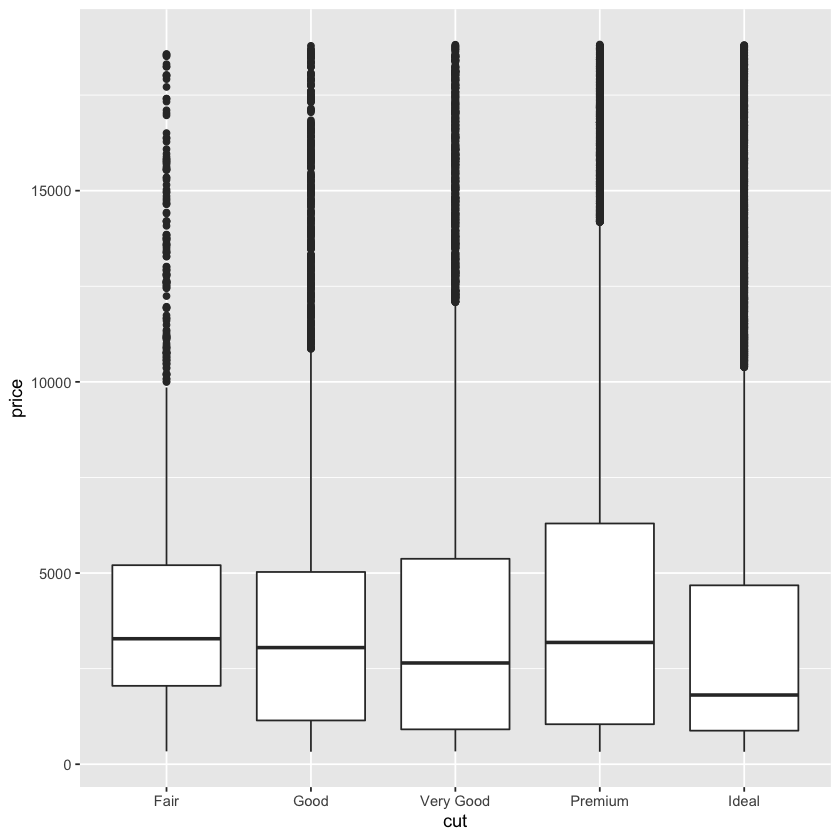

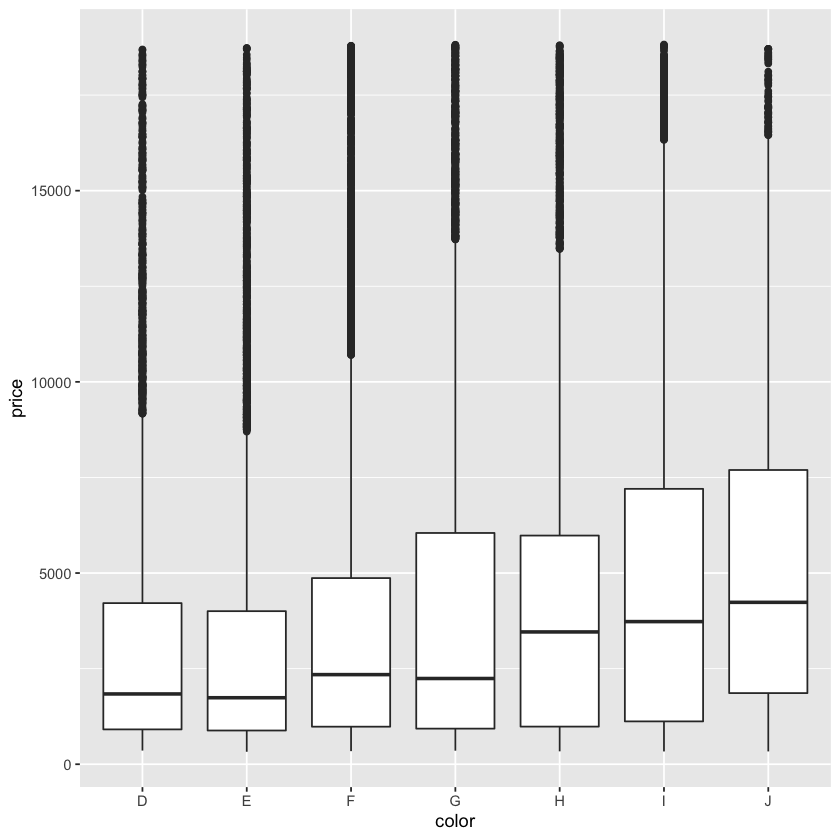

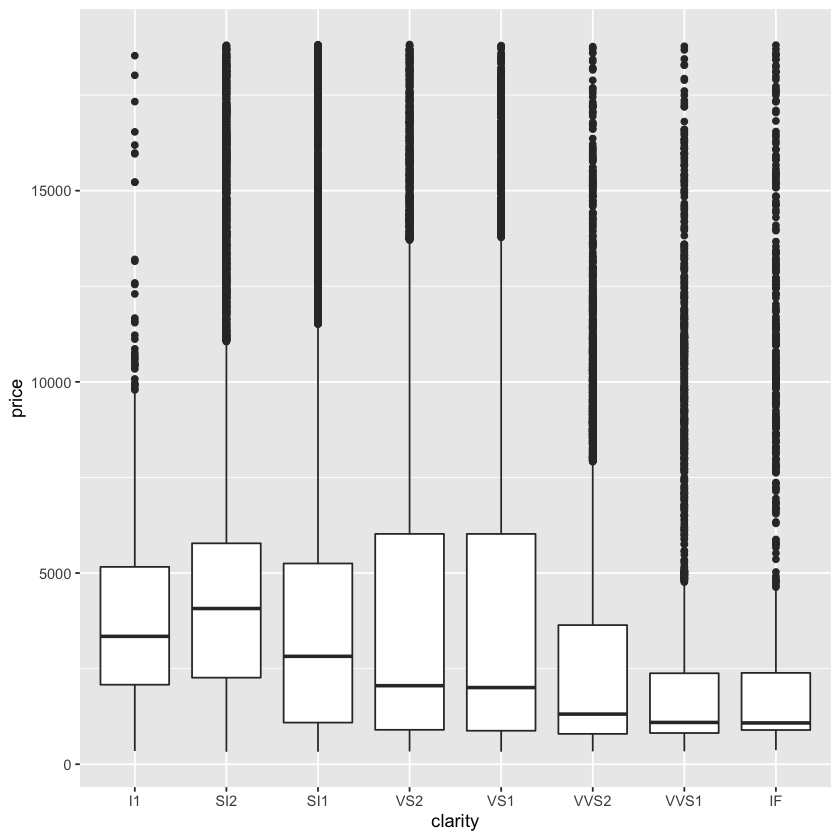

In [10]:
ggplot(diamonds, aes(cut, price)) + geom_boxplot()
ggplot(diamonds, aes(color, price)) + geom_boxplot()
ggplot(diamonds, aes(clarity, price)) + geom_boxplot()

- 퀄리티가 떨어지는 다이아몬드가 평균 단가는 제일 높은 것을 확인할 수 있는데 이는 무게(carat)를 고려하지 않았기 때문이다.<br>
일반적으로 품질이 떨어지는 다이아몬드가 더 무거운 경향이 있다.

Warning message:
“Computation failed in `stat_binhex()`:
”


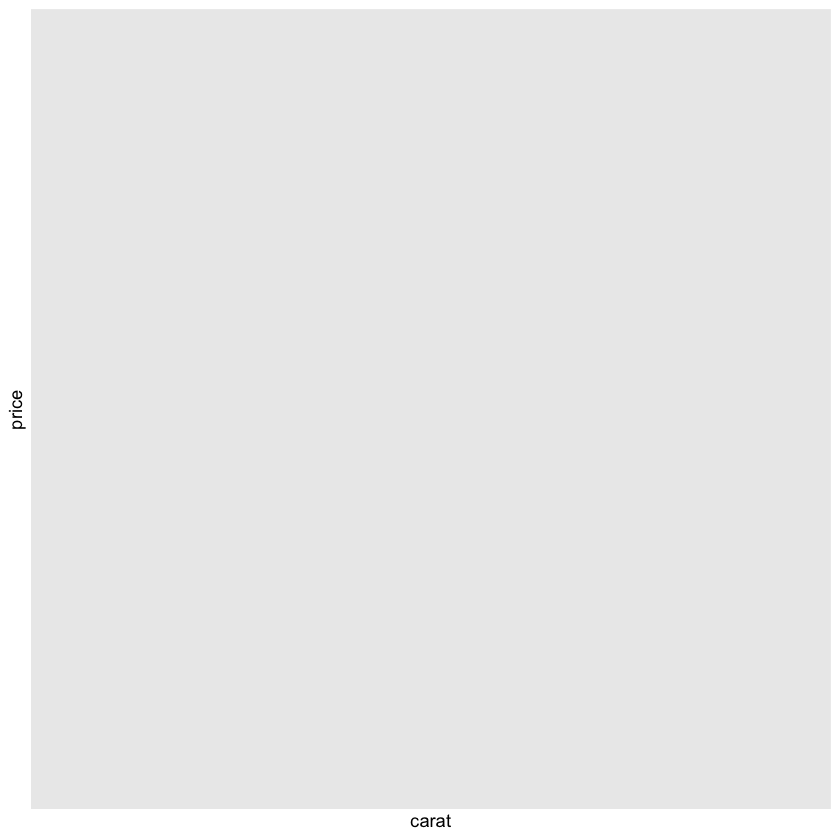

In [11]:
ggplot(diamonds, aes(carat, price)) +
geom_hex(bins = 50)

- carat의 효과를 분리하는 모델을 적합하여 다이아몬드의 다른 속성이 상대적으로 price에 어떻게 영향을 주는지 쉽게 알 수 있다.<br>
먼저 작업하기 쉽도록 만들기 위해 아래의 두 가지 항목으로 다이아몬드 데이터셋을 변경한다.<br>
1) 2.5캐럿보다 작은 다이아몬드(데이터의 99.7%에 해당)로 한정한다.<br>
2) 캐럿과 가격 변수를 로그 변환한다.

In [12]:
diamonds2 <- diamonds %>%
filter(carat <= 2.5) %>%
mutate(lprice = log2(price), lcarat = log2(carat))

In [13]:
diamonds2 %>% head

carat,cut,color,clarity,depth,table,price,x,y,z,lprice,lcarat
<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43,8.348728,-2.120294
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31,8.348728,-2.251539
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31,8.353147,-2.120294
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63,8.383704,-1.785875
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75,8.388017,-1.689660
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48,8.392317,-2.058894


- 이 변환은 carat과 price의 관계를 알기 쉽게 만들어준다.

Warning message:
“Computation failed in `stat_binhex()`:
”


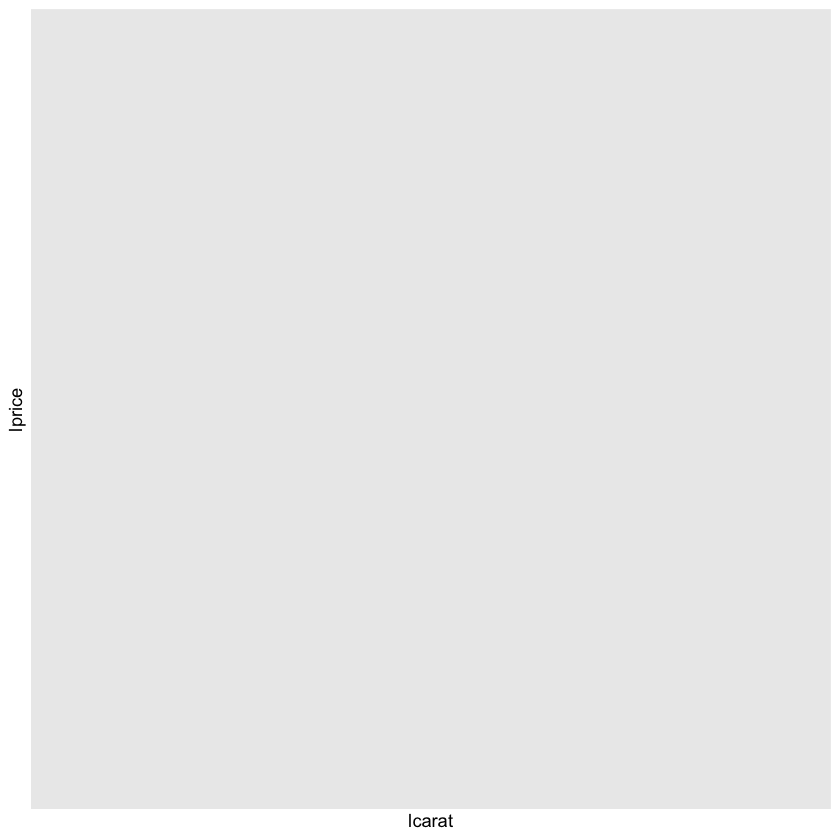

In [14]:
ggplot(diamonds2, aes(lcarat, lprice)) +
geom_hex(bins = 30)

- 로그 변환은 해당 패턴을 작업하기에 가장 쉬운 선형 패턴을 만들어주기 때문에 매우 유용하다. 다음 단계로 넘어가서 강한 선형 패턴을 제거해보자.<br>
먼저 모델을 적합하여 패턴을 명확하게 만든다.

In [15]:
mod_diamond <- lm(lprice ~ lcarat, data = diamonds2)
mod_diamond


Call:
lm(formula = lprice ~ lcarat, data = diamonds2)

Coefficients:
(Intercept)       lcarat  
     12.194        1.681  


Warning message:
“Computation failed in `stat_binhex()`:
”


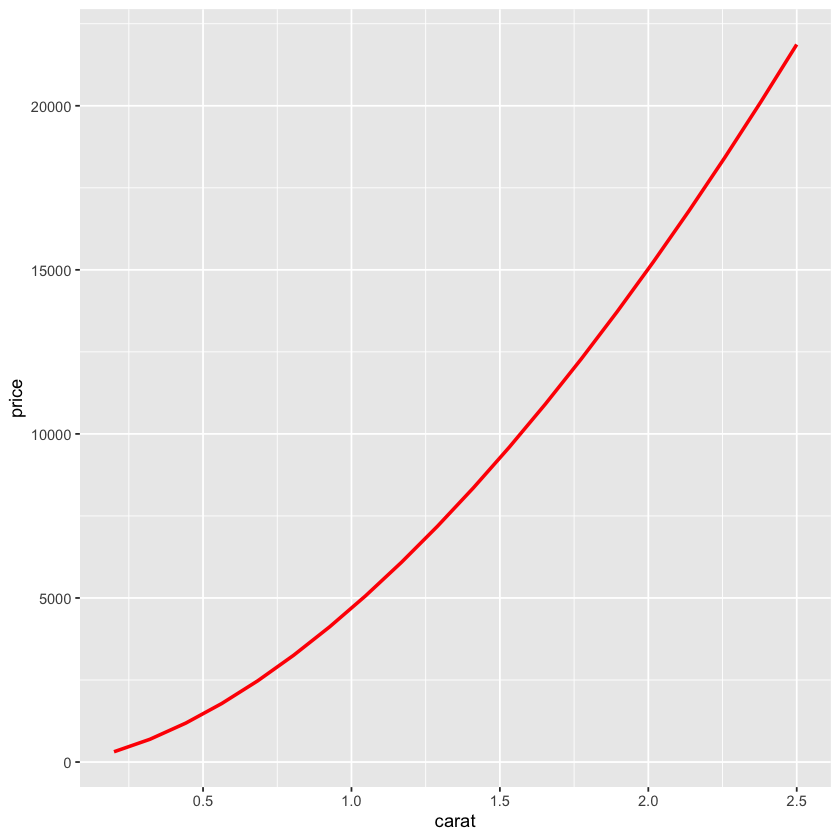

In [16]:
grid <- diamonds2 %>%
data_grid(carat = seq_range(carat, 20)) %>%
mutate(lcarat = log2(carat)) %>%
add_predictions(mod_diamond, "lprice") %>%
mutate(price = 2^lprice)

ggplot(diamonds2, aes(carat, price)) +
geom_hex(bins = 50) +
geom_line(data = grid, color = "red", size = 1)

- 위 플롯은 데이터에 대해 흥미로운 사실을 알려준다. 우리의 모델을 신뢰한다면 크기가 큰 다이아몬드는 예측한 값보다 훨씬 저렴하다.<br>
그것은 아마 이 데이터 셋에는 19,000달러가 넘는 다이아몬드가 존재하지 않기 때문이다.<br>
이제 강한 선형 패턴을 제대로 제거했는지 확인하기 위해 잔차를 살펴볼 수 있다.

Warning message:
“Computation failed in `stat_binhex()`:
”


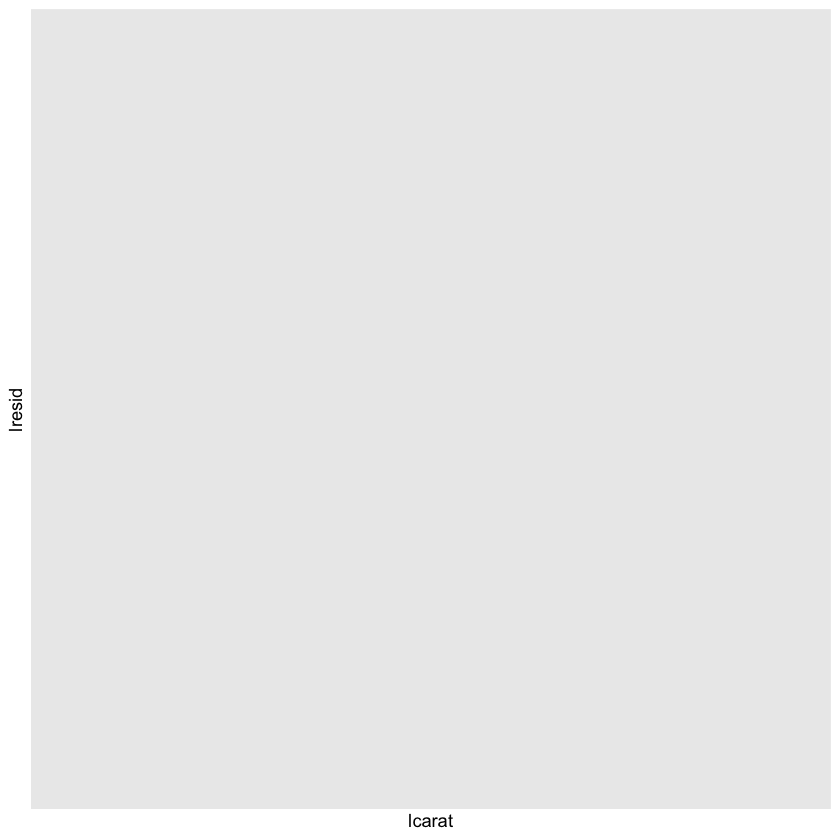

In [17]:
diamonds2 <- diamonds2 %>%
add_residuals(mod_diamond, "lresid")

ggplot(diamonds2, aes(lcarat, lresid)) +
geom_hex(bins = 50)

- 비교적 고른 잔차분포를 볼 수 있다.

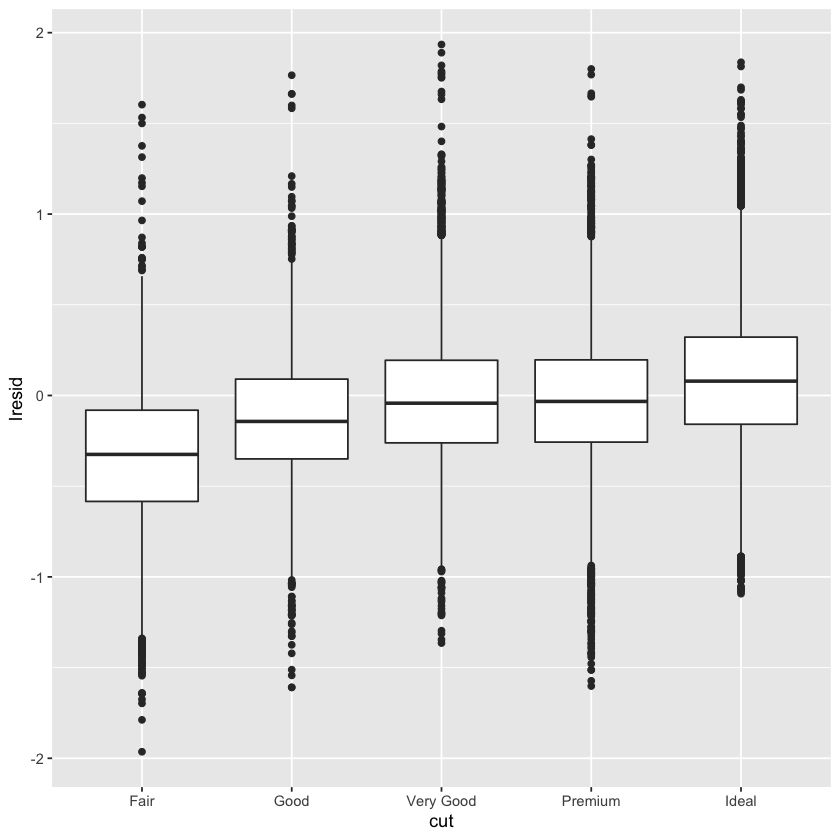

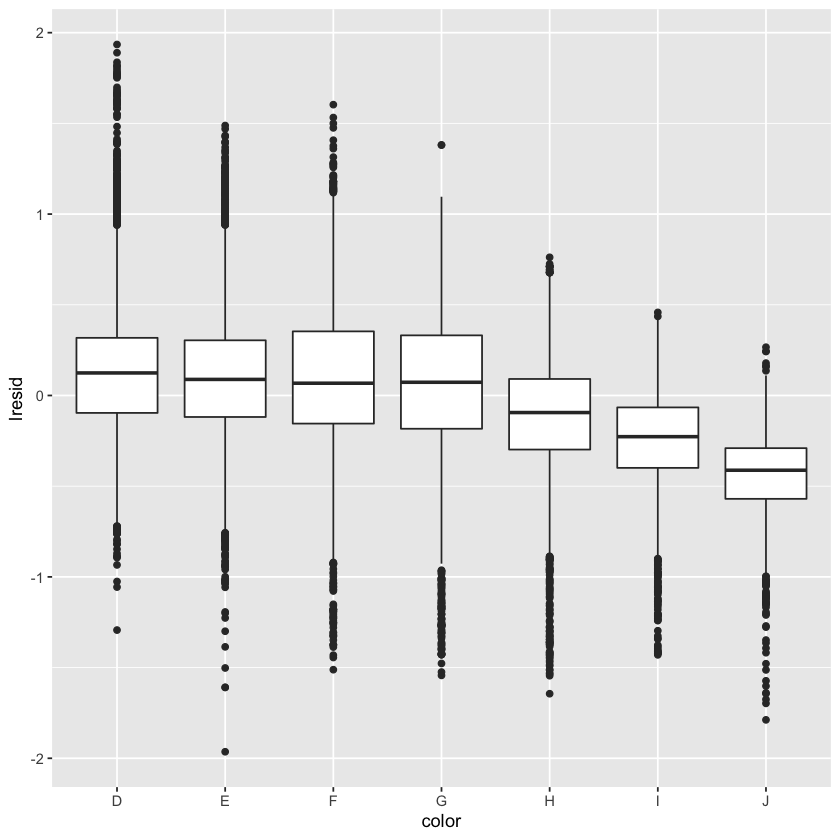

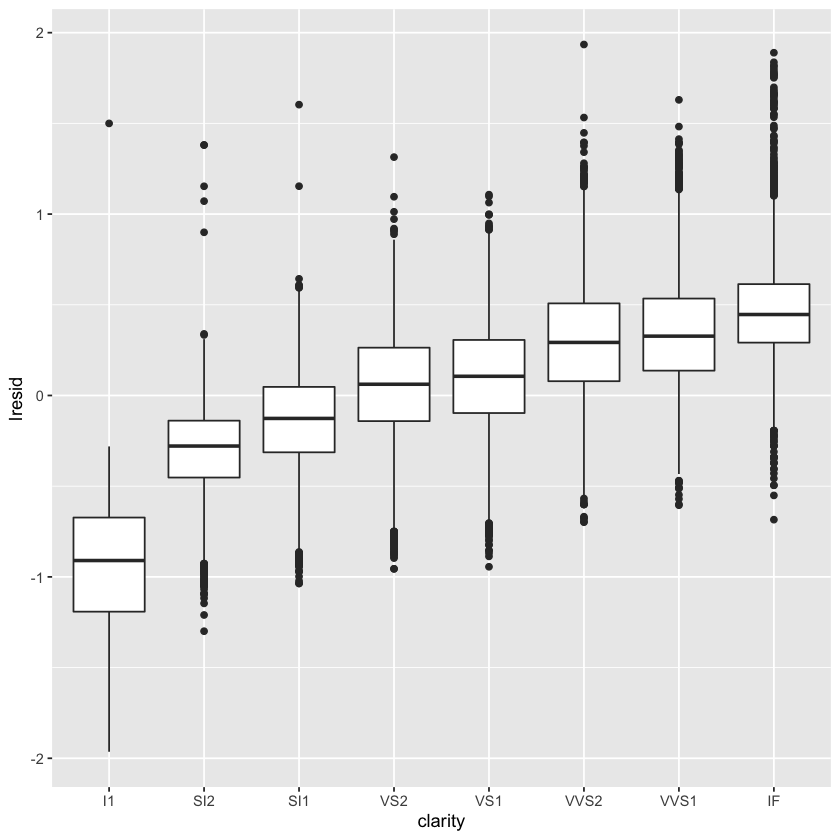

In [18]:
ggplot(diamonds2, aes(cut, lresid)) + geom_boxplot()
ggplot(diamonds2, aes(color, lresid)) + geom_boxplot()
ggplot(diamonds2, aes(clarity, lresid)) + geom_boxplot()

- 이제 예상했던 변수들의 관계를 확인할 수 있다. 다이아몬드의 품질이 좋아질수록 상대적인 가격도 높아진다.<br>
y축을 해석하기 위해 잔차의 의미와 스케일의 값에 대해 생각해볼 필요가 있다.<br>
잔차가 -1이라는 것은 해당 변수만을 이용한 예측값보다 lprice가 한 단위 더 작다는 것을 나타낸다.<br>
$2^{-1}$은 1/2이므로 -1인 점은 예측한 가격의 절반에 해당하고, 잔차가 1인 점은 예측한 가격의 두 배를 나타낸다.

### 더 복잡한 모델

- 원한다면 모델을 명시적으로 만들기 위해 관측한 효과를 모델로 이동하여 계속해서 모델을 발전시킬 수 있다.<br>
예를 들어 color, cut 및 clarity 변수를 모델에 포함하여 이 세 개의 범주형 변수의 효과를 나타낼 수 있다.

In [19]:
mod_diamond2 <- lm(
    lprice ~ lcarat + color + cut + clarity,
    data = diamonds2
    )

- 이제 이 모델은 네 개의 예측 변수를 포함하므로 시각화하는 것은 더 어려워진다. 그렇지만 모든 변수가 독립적이므로 네 개의 플롯으로 각각 그릴 수 있다.<br>
이 과정을 좀 더 쉽게 만들기 위해 `data_grid`함수에 `.model`인수를 사용한다.

In [20]:
grid <- diamonds2 %>%
data_grid(cut, .model = mod_diamond2) %>%
add_predictions(mod_diamond2)

grid

cut,lcarat,color,clarity,pred
<ord>,<dbl>,<chr>,<chr>,<dbl>
Fair,-0.5145732,G,VS2,11.20557
Good,-0.5145732,G,VS2,11.32050
Very Good,-0.5145732,G,VS2,11.37396
Premium,-0.5145732,G,VS2,11.40627
Ideal,-0.5145732,G,VS2,11.43759


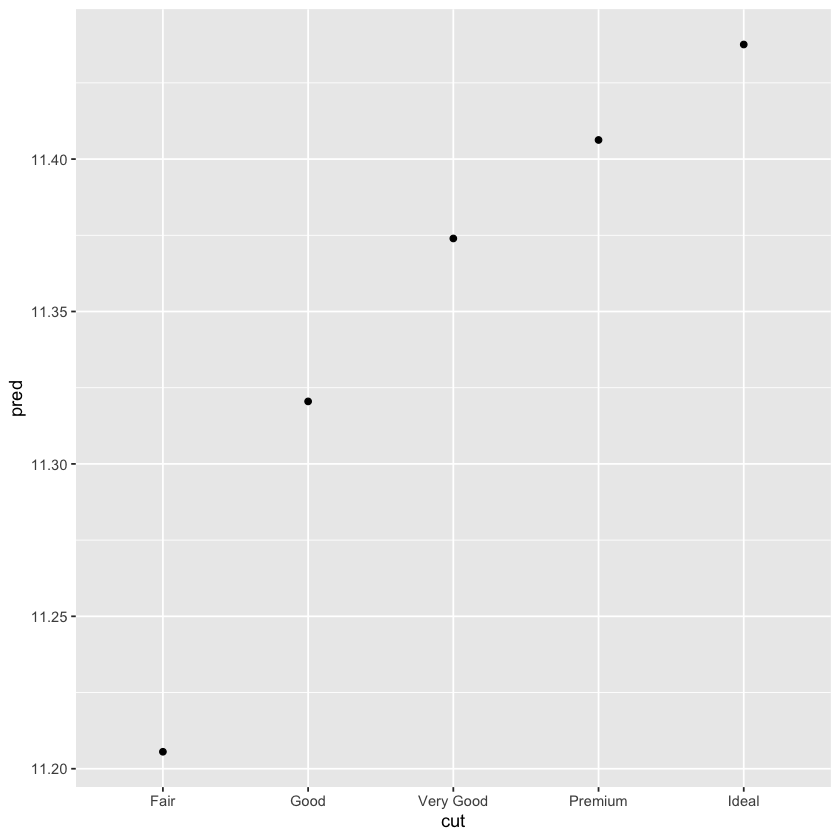

In [21]:
ggplot(grid, aes(cut, pred)) +
geom_point()

- 명시적으로 제공되지 않는 변수를 모델이 필요로 한다면 `data_grid()`함수가 자동으로 '대표적인 값'으로 채운다.<br>
연속형 변수의 경우 중앙값을 사용하고, 범주형 변수의 경우 가장 빈번한 값을 사용한다.

Warning message:
“Computation failed in `stat_binhex()`:
”


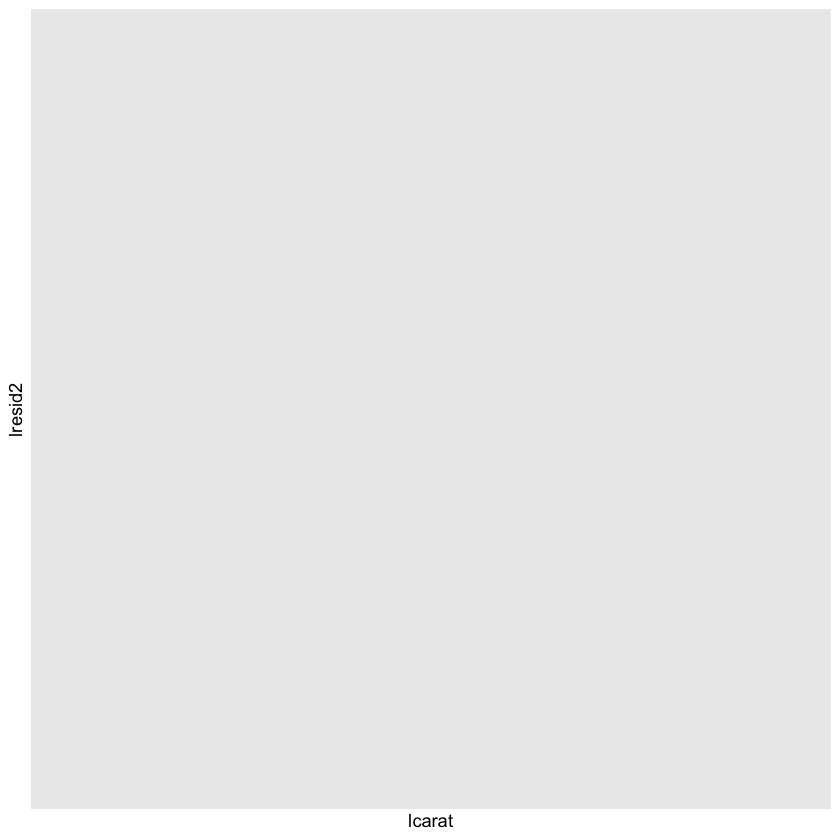

In [22]:
diamonds2 <- diamonds2 %>%
add_residuals(mod_diamond2, "lresid2")

ggplot(diamonds2, aes(lcarat, lresid2)) +
geom_hex(bins = 50)

- 이 플롯은 잔차의 값이 큰 다이아몬드가 일부 존재한다는 것을 보여준다. 잔차가 2라는 것은 다이아몬드의 가격이 예상했던 가격의 4배라는 것을 나타낸다.<br>
비정상적인 관측값을 개별적으로 탐색하면 유용할 때가 많다.

In [23]:
diamonds2 %>%
filter(abs(lresid2) > 1) %>%
add_predictions(mod_diamond2) %>%
mutate(pred = round(2^pred)) %>%
select(price, pred, carat:table, x:z) %>%
arrange(price)

price,pred,carat,cut,color,clarity,depth,table,x,y,z
<int>,<dbl>,<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1013,264,0.25,Fair,F,SI2,54.4,64,4.30,4.23,2.32
1186,284,0.25,Premium,G,SI2,59.0,60,5.33,5.28,3.12
1186,284,0.25,Premium,G,SI2,58.8,60,5.33,5.28,3.12
1262,2644,1.03,Fair,E,I1,78.2,54,5.72,5.59,4.42
1415,639,0.35,Fair,G,VS2,65.9,54,5.57,5.53,3.66
1415,639,0.35,Fair,G,VS2,65.9,54,5.57,5.53,3.66
1715,576,0.32,Fair,F,VS2,59.6,60,4.42,4.34,2.61
1776,412,0.29,Fair,F,SI1,55.8,60,4.48,4.41,2.48
2160,314,0.34,Fair,F,I1,55.8,62,4.72,4.60,2.60


- 여기서는 분명하게 눈에 띄는 것은 없지만, 모델에 문제가 있는지 혹은 데이터에 오류가 있는지 생각해보는 데 시간을 투자할 가치가 있다.<br>
만약 데이터에 오류가 있다면 부정확하게 낮은 가격으로 가격이 매겨진 다이아몬드를 사게 될 수도 있다.

## 예제2) 일일 운항 횟수에 어떤 영향이 있는가?

`-` 일자별 항공편의 빈도수

In [24]:
daily <- flights %>%
mutate(date = make_date(year, month, day)) %>%
group_by(date) %>%
summarize(n = n())

daily %>% head

date,n
<date>,<int>
2013-01-01,842
2013-01-02,943
2013-01-03,914
2013-01-04,915
2013-01-05,720
2013-01-06,832


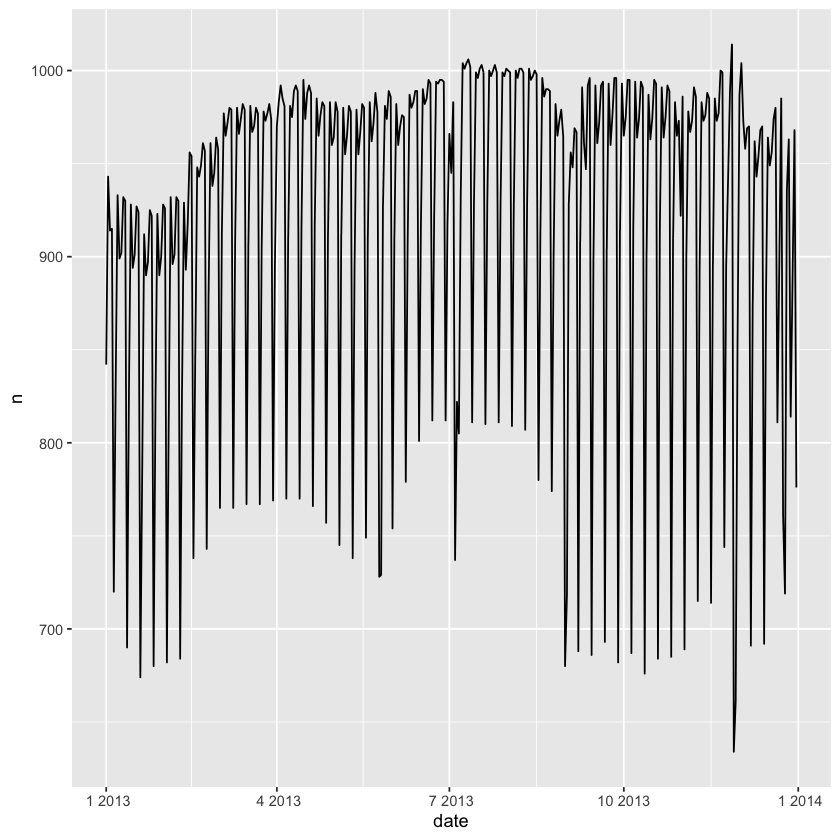

In [25]:
ggplot(daily, aes(date, n)) +
geom_line()

### 요일

- 요일 효과가 매우 강하게 존재하기 때문에 장기적인 트렌드를 이해하기 쉽지 않다. 먼저 요일별 항공편의 수에 대한 분포를 보면

In [26]:
daily <- daily %>%
mutate(wday = wday(date, label = TRUE))

- 한글로 나와서 오류떠서 영어로 바꿔줌

In [27]:
daily <- daily %>%
mutate(wday = fct_recode(wday,
                            "Sun"   = "일",
                            "Mon"   = "월",
                            "Tues"  = "화",
                            "Wed"   = "수",
                            "Thurs" = "목",
                            "Fri"   = "금",
                            "Sat"   = "토"
                            ))

In [28]:
daily %>% head

date,n,wday
<date>,<int>,<ord>
2013-01-01,842,Tues
2013-01-02,943,Wed
2013-01-03,914,Thurs
2013-01-04,915,Fri
2013-01-05,720,Sat
2013-01-06,832,Sun


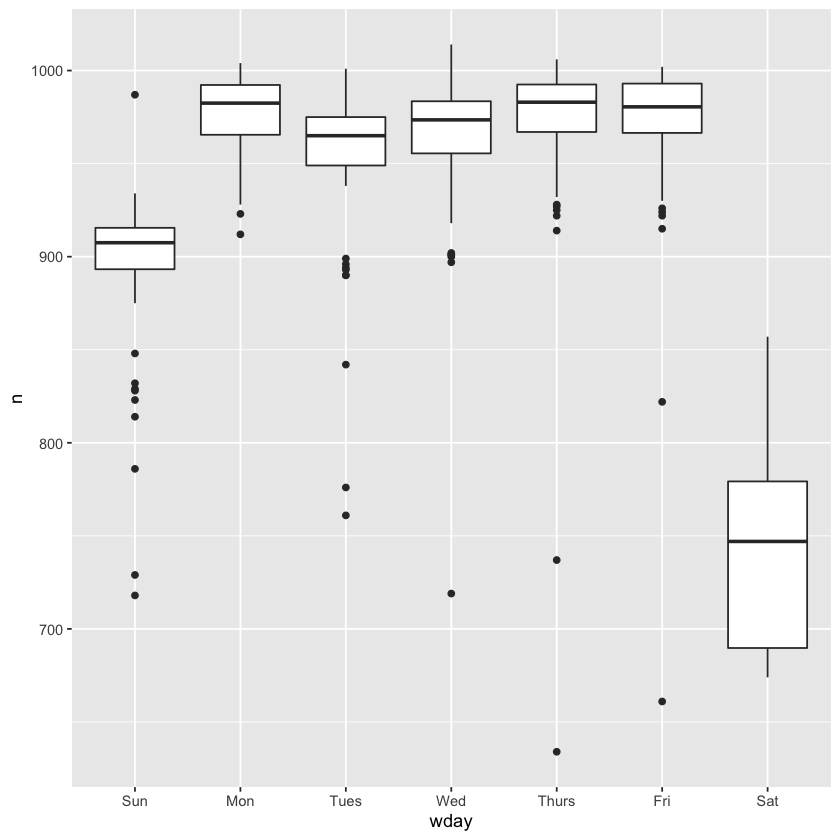

In [29]:
ggplot(daily, aes(wday, n)) +
geom_boxplot()

- 대부분 업무를 위해 비행기를 이용하므로 주말에는 항공편의 수가 적다.<br>
그 효과는 특히 토요일에 두드러지게 나타난다. 월요일 아침 미팅을 위해 일요일에 떠나는 경우는 있지만, 토요일에는 가족과 함께 집에 있는 것을 택할 것이므로 토요일에 떠나는 경우는 거의 없다.<br>
이 강력한 패턴을 제거하는 한 가지 방법은 모델을 사용하는 것이다. 먼저 모델을 생성하고 원 데이터에 예측값을 겹처서 나타낸다.

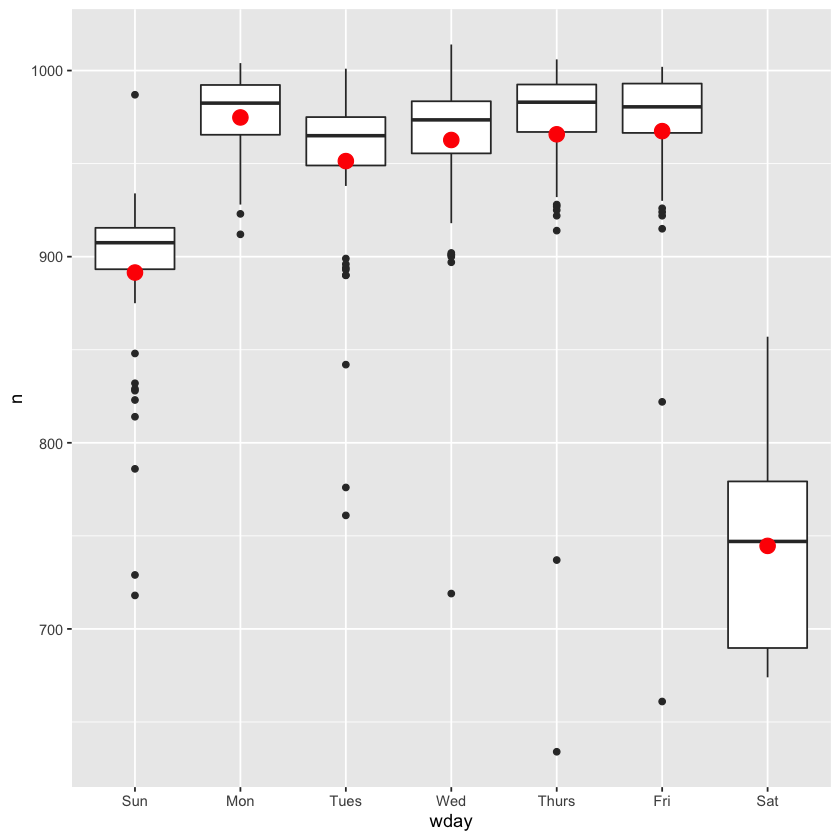

In [30]:
mod <- lm(n ~ wday, data = daily)

grid <- daily %>%
data_grid(wday) %>%
add_predictions(mod, "n")

ggplot(daily, aes(wday, n)) +
geom_boxplot() +
geom_point(data = grid, color = "red", size = 4)

- 다음으로 잔차를 계산한 후 시각화한다.

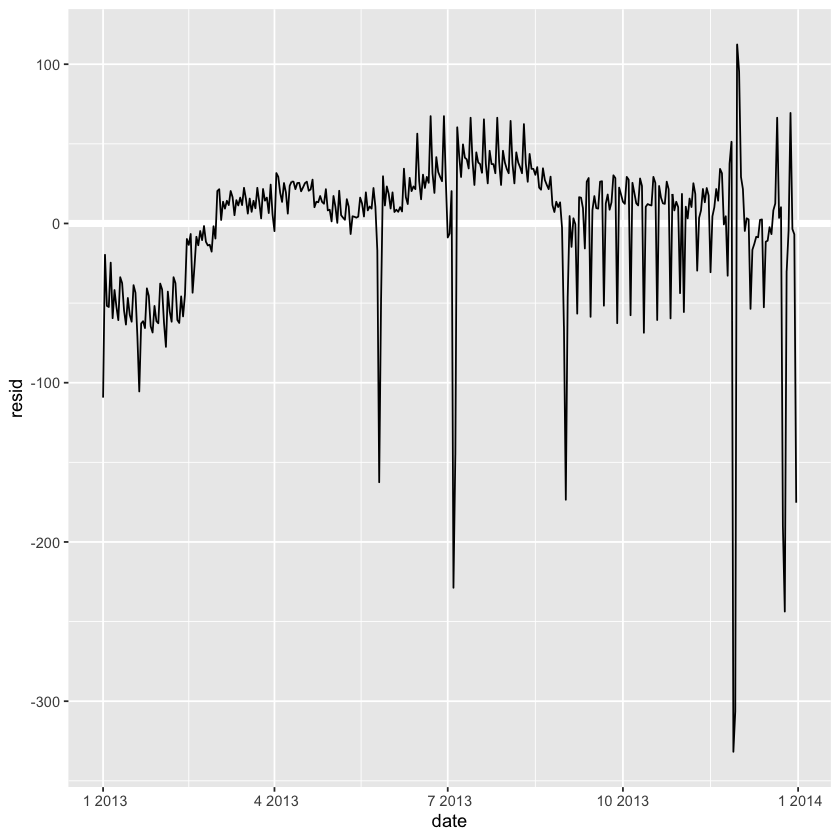

In [31]:
daily <- daily %>%
add_residuals(mod)

daily %>%
ggplot(aes(date, resid)) +
geom_ref_line(h = 0) +
geom_line()

- y축 변화를 보면 일자마다 예측한 비행 횟수의 편차를 확인할 수 있다.<br>
요일 효과의 많은 부분을 제거하여 남아있는, 감지하기 어려운 패턴을 확인할 수 있으므로 이 플롯은 유용하다고 할 수 있다.<br>
이 모델은 6월부터 잘 맞지 않는 것처럼 보인다. 여전히 모델이 포착하지 못한 규칙적이고 강한 패턴을 확인할 수 있다.<br>
각 요일을 한 줄씩 플롯으로 그리면 그 원인을 쉽게 확인할 수 있다.

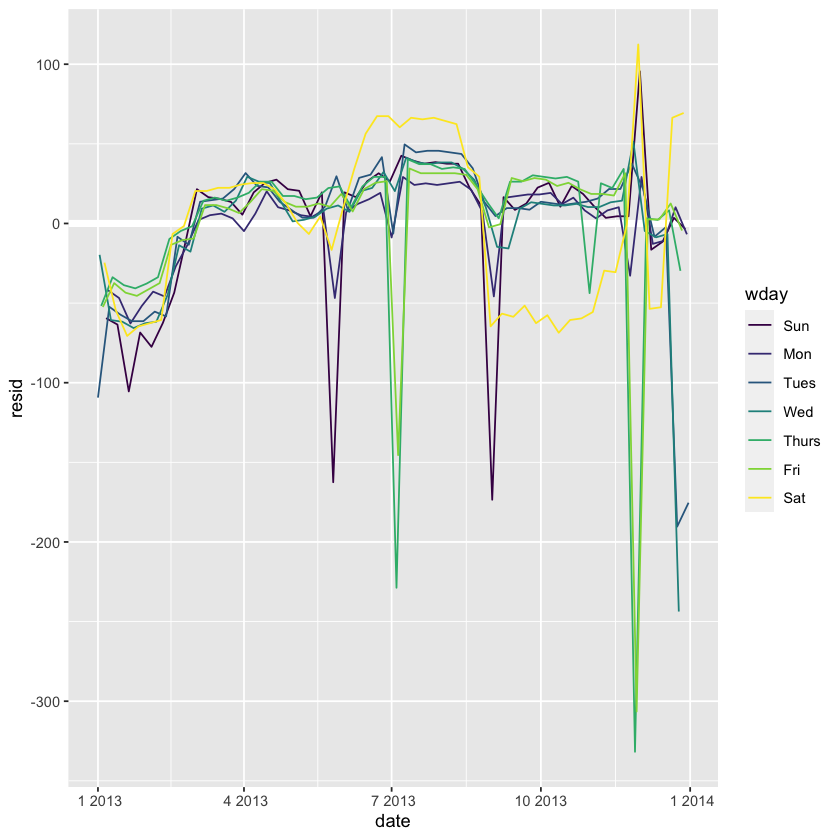

In [32]:
ggplot(daily, aes(date, resid, color = wday)) +
geom_ref_line(h = 0) +
geom_line()

- 위의 모델은 플롯으로 보았을 때 토요일의 비행 횟수를 정확하게 예측하지 못한다. 여름에는 예측한 값보다 많은 항공편이 있고, 가을에는 더 적은 항공편이 있다.

In [33]:
daily %>%
filter(resid < -100)

date,n,wday,resid
<date>,<int>,<ord>,<dbl>
2013-01-01,842,Tues,-109.3585
2013-01-20,786,Sun,-105.4808
2013-05-26,729,Sun,-162.4808
2013-07-04,737,Thurs,-228.7500
2013-07-05,822,Fri,-145.4615
2013-09-01,718,Sun,-173.4808
2013-11-28,634,Thurs,-331.7500
2013-11-29,661,Fri,-306.4615
2013-12-24,761,Tues,-190.3585


- 1년에 걸친 장기간의 매끄러운 추세가 나타나는 것처럼 보이는데 `geom_smooth()`을 사용하여 이러한 추세를 강조할 수 있다.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



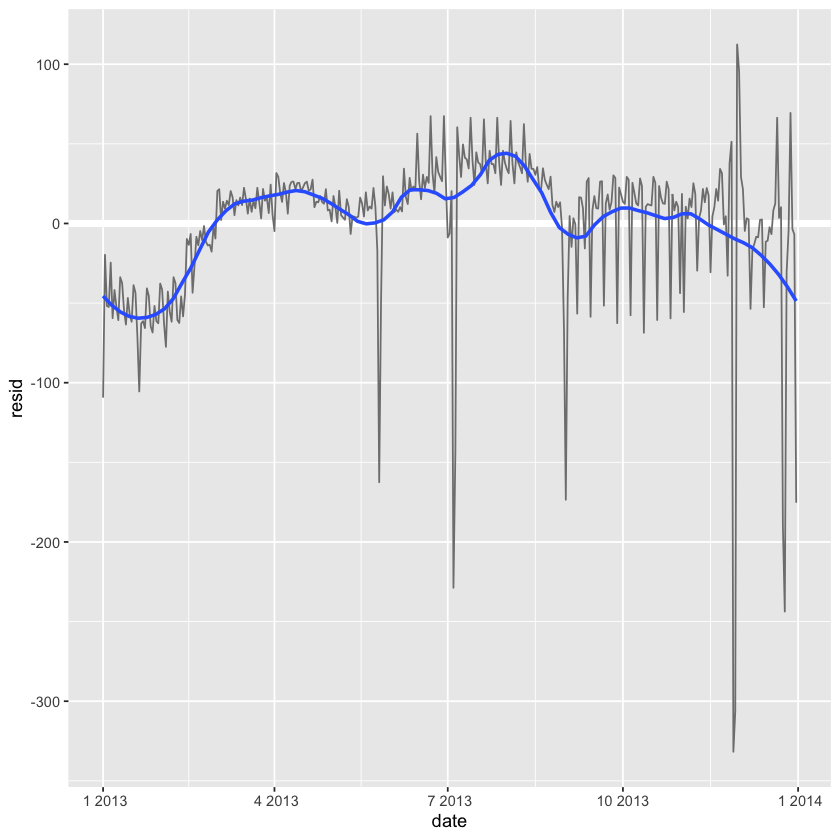

In [34]:
daily %>%
ggplot(aes(date, resid)) +
geom_ref_line(h = 0) +
geom_line(color = "grey50") +
geom_smooth(se = FALSE, span = 0.20)

- 항공편의 수는 1월(그리고 12월)에 더 적고, 여름(5월~9월)에 더 많다. 데이터가 1년치밖에 없으므로 이 패턴을 정량적으로 많이 다룰 수 없다.<br>
그렇지만 도메인 지식을 사용하여 잠재적인 이유를 생각해 낼 수 있다.

### 주기적인 토요일 효과

- 먼저 토요일의 비행 횟수를 정확하게 예측하지 못한 문제를 다뤄보면 처음에는 토요일로 한정한 원 데이터로 돌아가는 것이 좋다.

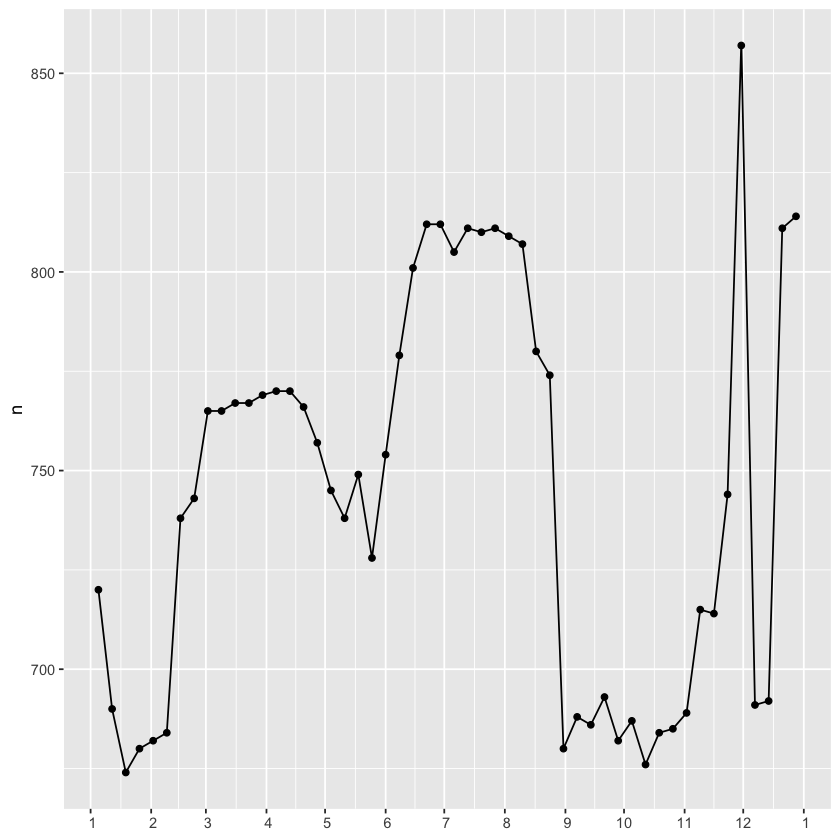

In [35]:
daily %>%
filter(wday == "Sat") %>%
ggplot(aes(date, n)) +
geom_point() +
geom_line() +
scale_x_date(
    NULL,
    date_breaks = "1 month",
    date_labels = "%b"
    )

- 이 패턴은 여름 휴가로 인해 발생된 것으로 추측하다. 사람들은 대부분 여름에 휴가를 휴가를 위해 토요일에 출발하는 것을 개의치 않는다.<br>
이 플롯을 보면 여름 휴가 기간은 6월 초에서 8월 말까지로 추측할 수 있다.<br>
이 기간은 주립 학교의 여름방학 기간(2013년의 여름방학은 6월 26일부터 9월 9일까지)과 꽤 잘 맞는 것처럼 보인다.<br>
가을보다 봄에 토요일 비행이 더 많은 이유는 무엇인가? 미국인 친구들에게 물어보니 가을에는 추수감사절과 크리스마스가 있어 가족 휴가를 계획하는 것이 일반적이지 않다는 의견을
주었다. 확신할 수 있는 데이터는 없지만 그럴듯한 가설인 것 같다.<br>
대략 세 개의 학기를 포함하는 '학기(term)'변수를 만들고 플롯으로 확인해보자.

In [36]:
term <- function(date){
    cut(date,
        breaks = ymd(20130101, 20130605, 20130825, 20140101),
        labels = c("spring", "summer", "fall")
        )
    }

daily <- daily %>%
mutate(term = term(date))

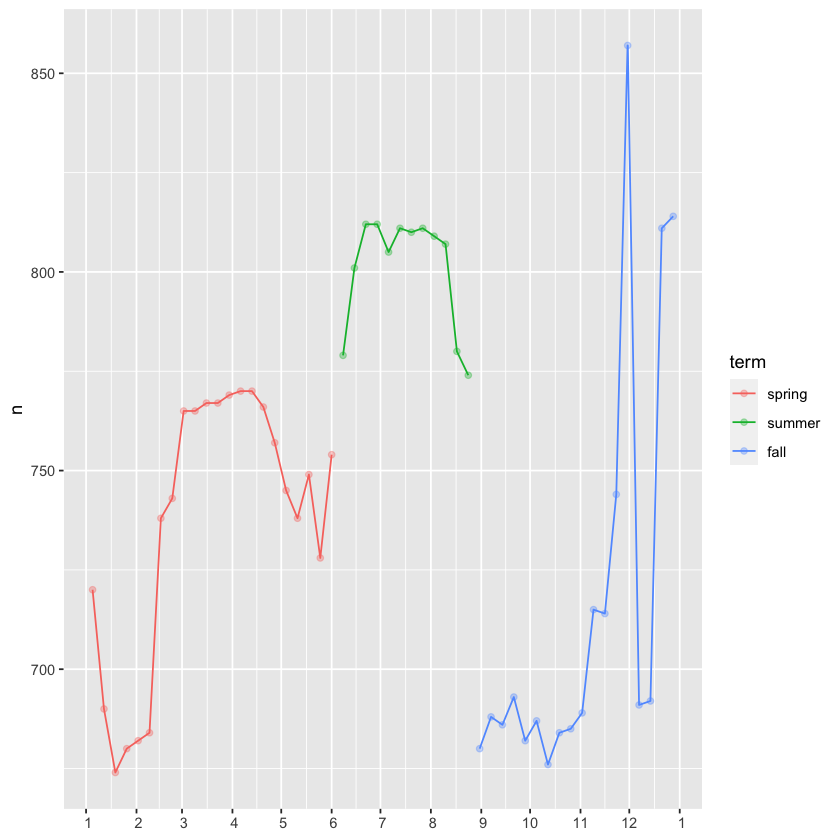

In [37]:
daily %>%
filter(wday == "Sat") %>%
ggplot(aes(date, n, color = term)) +
       geom_point(alpha = 1/3) +
       geom_line() +
       scale_x_date(
           NULL,
           date_breaks = "1 month",
           date_labels = "%b"
           )

- 이 플롯에서는 변화를 잘 나타내기 위해 날짜를 수동으로 조정했다. 시각화를 사용하여 함수의 역할을 이용하도록 도와주는 것은 매우 강력하고 일반적인 기술이다.<br>
이 새로운 변수가 다른 요인에 어떤 영향을 미치는지 확인하는 것은 유용하다.

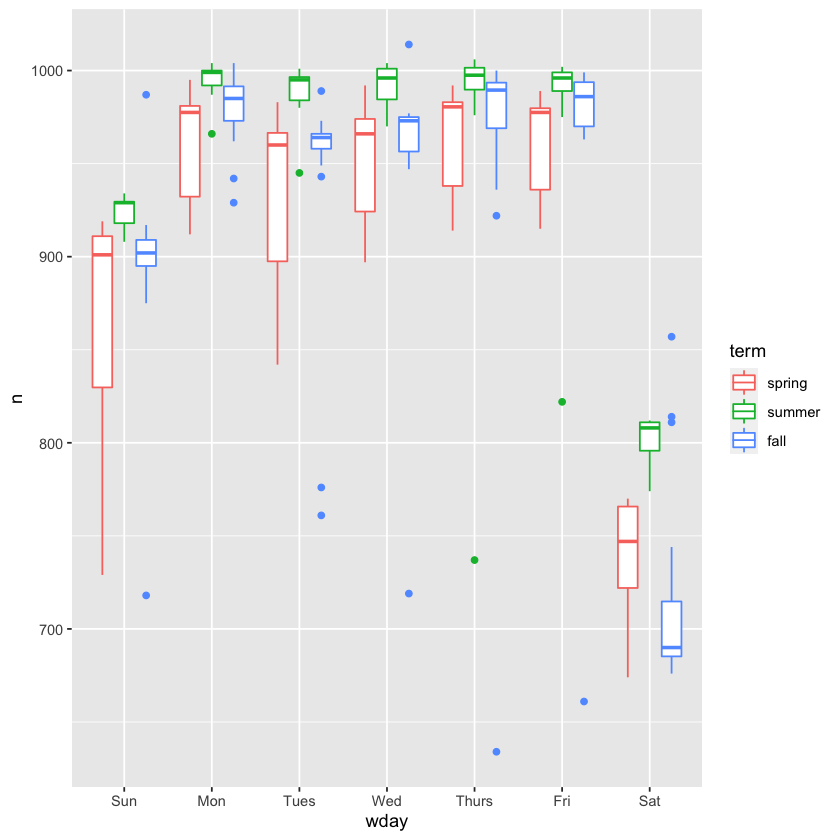

In [38]:
daily %>%
ggplot(aes(wday, n, color = term)) +
geom_boxplot()

- 학기 전반에 걸쳐 상당한 변동이 있는 것처럼 보이므로 각 학기에 대해 별도의 요일 효과를 적용하는 것이 합리적이다. <br>
요일 효과는 모델을 개선하기는 하지만 기대할 수 있는 만큼은 아니다.

In [39]:
mod1 <- lm(n ~ wday, data = daily)
mod2 <- lm(n ~ wday * term, data = daily)

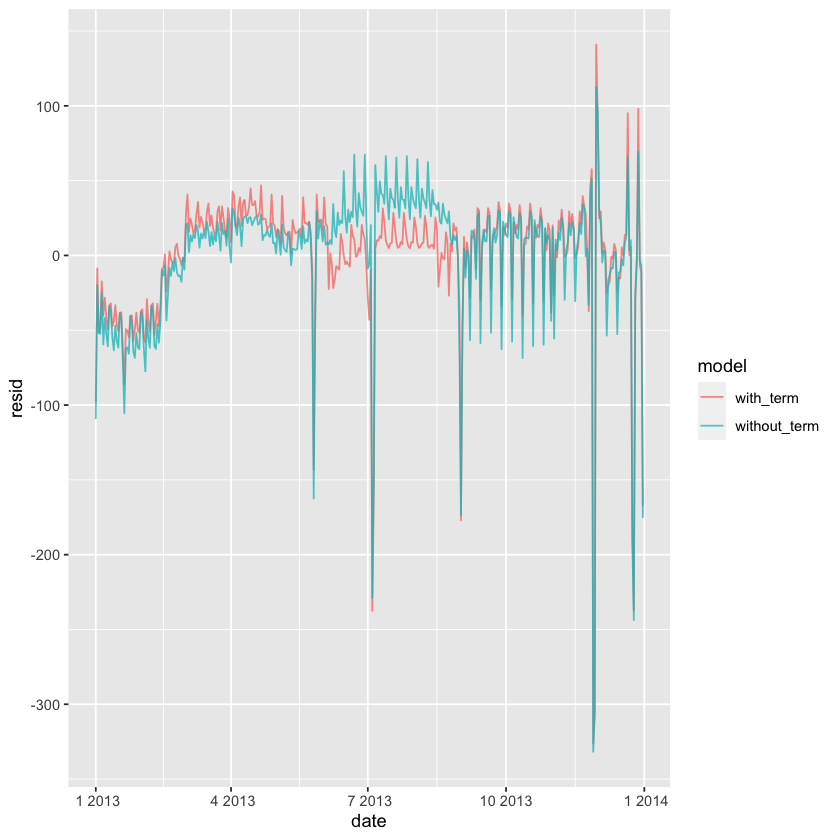

In [40]:
daily %>%
gather_residuals(without_term = mod1, with_term = mod2) %>%
ggplot(aes(date, resid, color = model)) +
geom_line(alpha = 0.75)

- 모델로 예측한 값을 원 데이터에 겹쳐 그리면 문제를 확인할 수 있다.

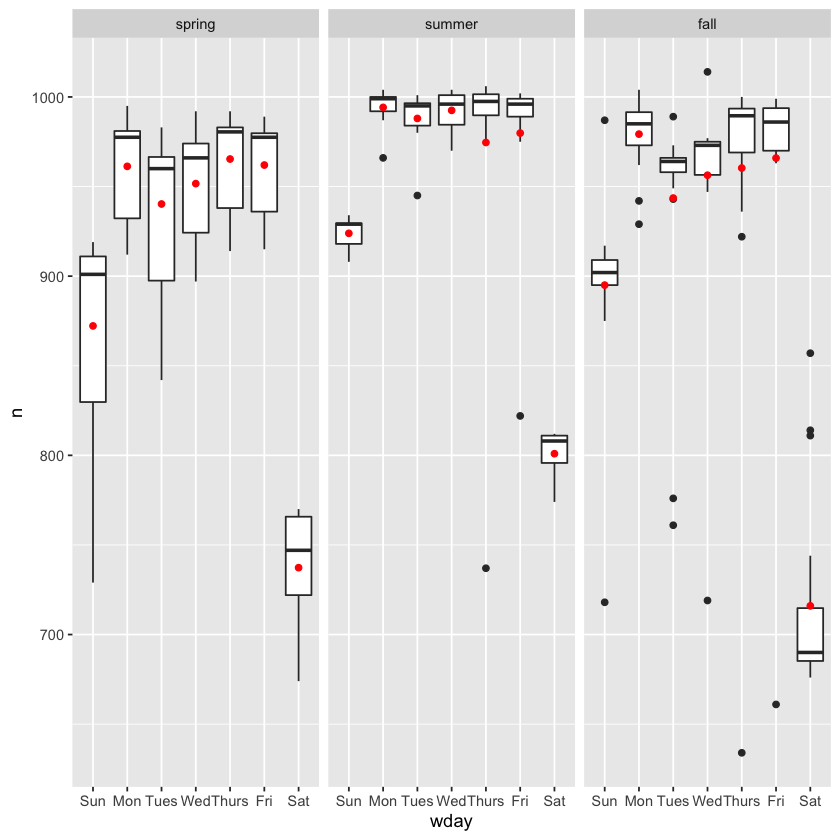

In [41]:
grid <- daily %>%
data_grid(wday, term) %>%
add_predictions(mod2, "n")

ggplot(daily, aes(wday, n)) +
geom_boxplot() +
geom_point(data = grid, color = "red") +
facet_wrap(~ term)

모델은 평균 효과를 찾지만, 값이 큰 이상값들이 많이므로 평균값은 일반적인 값과 멀어지는 경향이 있다. 이 문제는 이상값에 영향을 덜 받는(robust)모델을 사용하여 
완화할 수 있다.<br>
바로 `MASS::rlm()`을 사용하는 것이다. 이 함수는 이상값이 추정값에 미치는 영향을 줄이고 요일 패턴을 제거하는 모델을 제공한다.

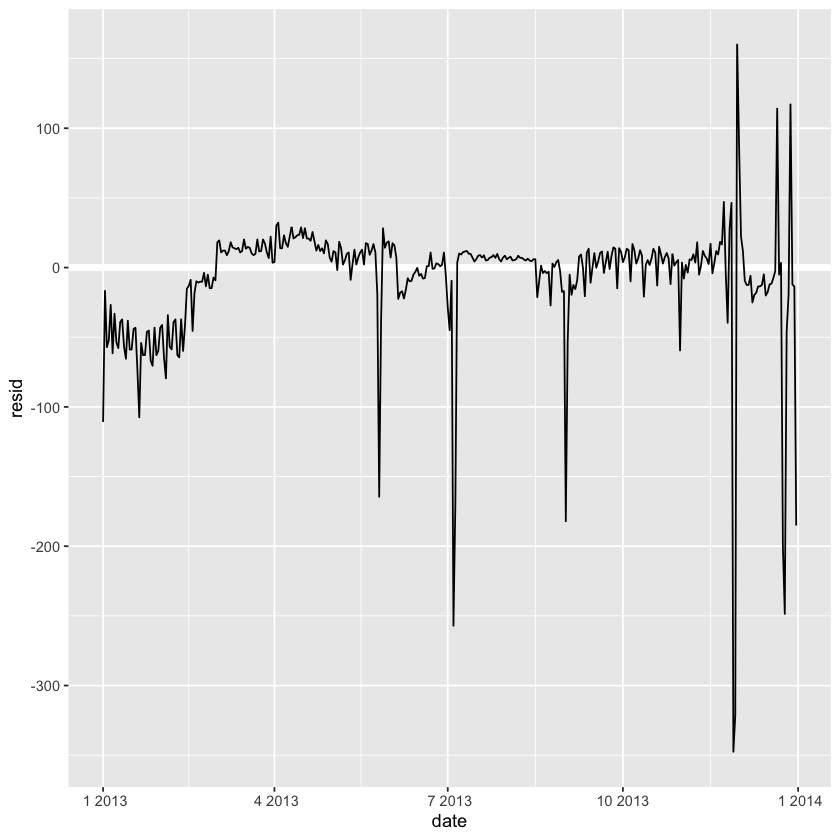

In [42]:
mod3 <- MASS::rlm(n ~ wday * term, data = daily)

daily %>%
add_residuals(mod3, "resid") %>%
ggplot(aes(date, resid)) +
geom_hline(yintercept = 0, size = 2, color = "white") +
geom_line()

장기적인 추세와 양과 음의 이상값을 훨씬 쉽게 확인할 수 있다.

### 계산된 변수

- 많은 모델과 시각화를 경험해보고 있다면 변수 생성 과정을 함수로 묶어 항상 같은 변형을 적용하는 것이 좋다. 예를 들어 다음과 같이 작성할 수 있다.

In [43]:
compute_vars <- function(data){
    data %>%
    mutate(
        term = term(date),
        wday = wday(date, label = TRUE)
        )
    }

- 또 다른 옵션은 모델 수식셍 변형을 바로 넣는 것이다.

In [44]:
wday2 <- function(x) wday(x, label = TRUE)
mod3 <- lm(n ~ wday2(date) * term(date), data = daily)

- 두 방법 모두 합리적이다. 변형된 변수를 명시적으로 만드는 것은 작업을 확인하거나 변수를 시각화에 사용하려는 경우 유용하다.<br>
그러나 여러 열을 반환하는 변형(예: 스플라인)은 쉽게 사용할 수 없다.<br>
모델 함수에 변형을 포함하면 모델 자체에서 변형되기 때문에 다양한 데이터셋으로 작업하는 경우에 좀 더 쉽게 사용할 수 있다.

### 연중 시각: 다른 접근법

이전 절에서는 모델을 향상하기 위해 도메인 지식(미국의 학기가 여행에 미치는 영향)을 사용했다.<br>
모델에 명시적으로 지식을 포함시키는 방법 대신 다차원의 데이터를 포함하도록 하는 방식도 있다.<br>
그것은 더 유연한 모델을 사용하여 관심 있는 패턴을 포착하는 것이다.<br>
이때 간단한 선형 추세는 적합하지 않기 때문에 1년의 기간에 대해서 매끄러운 곡선을 적합하기 위해 자연스러운 스플라인을 적용해볼 수 있다.

In [45]:
library('splines')

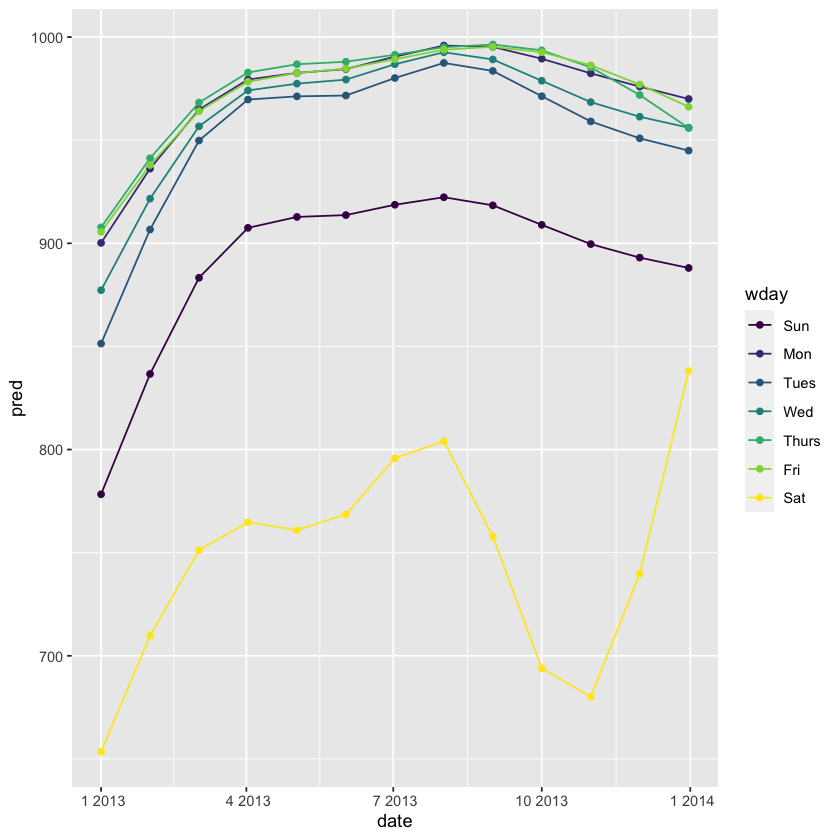

In [46]:
mod <- MASS::rlm(n ~ wday * ns(date, 5), data = daily)

daily %>%
data_grid(wday, date = seq_range(date, n = 13)) %>%
add_predictions(mod) %>%
ggplot(aes(date, pred, color = wday)) +
geom_line() +
geom_point()

- 토요일의 비행 횟수에서 강한 패턴을 확인할 수 있다. 이는 원 데이터에서 보았던 패턴이므로 안심할 수 있는 결과이다.<br>
서로 다른 접근법으로 같은 시그널을 얻는다면 그건 좋은 신호라 할 수 있다.